# Car Fuel Consumption 演習

https://www.kaggle.com/anderas/car-consume

In [280]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ

## データ読み込みと、そのオリジナルデータの表示

- データ取得元
  - https://www.kaggle.com/anderas/car-consume/downloads/car-consume.zip/5

In [281]:
# 学習データを CSV ファイルから読み込む
df = pd.read_csv("../../../car-consume/measurements.csv")
# オリジナルのデータを表示
display(df.head(10))

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN
5,"8,3","6,4",50,"21,5",10,NaN,E10,0,0,0,NaN,NaN
6,"7,8","4,4",43,"21,5",11,NaN,E10,0,0,0,NaN,NaN
7,"12,3",5,40,"21,5",6,NaN,E10,0,0,0,NaN,NaN
8,"4,9","6,4",26,"21,5",4,NaN,E10,0,0,0,NaN,NaN
9,"11,9","5,3",30,"21,5",9,NaN,E10,0,0,0,NaN,NaN


## データの加工

- 元データ内の小数の表記が「 10,5 」のような形であったため、これを「 10.5 」のような形式に置換（ pandas の replace 関数を利用）

- 元データのうち、temp_inside カラムに空データが含まれている行があったため、これを同カラムの平均値で置き換えることとする。（ pandas の fillna 関数を利用）

- 元データの gas_type カラムの値については、文字列で格納されている値を数値に変換（ "SP98" -> 0, "E10" -> 1 ）

In [282]:
# 小数点を表す文字を「,」から「.」に置換し、データを文字列型から浮動小数点型に変換する
df['distance'] = df['distance'].str.replace(',', '.').astype(float)
df['consume'] = df['consume'].str.replace(',', '.').astype(float)
df['temp_inside'] = df['temp_inside'].str.replace(',', '.').astype(float)

# temp_inside カラムに空文字列データが含まれていれば、その行の値を、temp_inside の平均値に置換
df['temp_inside'].fillna(df['temp_inside'].mean(), inplace=True)

# gas_type カラムの値を数値に置換（ "SP98" -> 0, "E10" -> 1 ）
df['gas_type'].replace({'SP98': 0, 'E10': 1}, inplace=True)

## 加工済みデータを表示

- 加工済みデータの一部と、describe 関数の結果を表示

In [283]:
# データを表示
display(df.head(10))
df.describe()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,1,0,0,0,45,E10
1,12.0,4.2,30,21.5,13,NaN,1,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,1,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,1,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,1,0,0,0,NaN,NaN
5,8.3,6.4,50,21.5,10,NaN,1,0,0,0,NaN,NaN
6,7.8,4.4,43,21.5,11,NaN,1,0,0,0,NaN,NaN
7,12.3,5.0,40,21.5,6,NaN,1,0,0,0,NaN,NaN
8,4.9,6.4,26,21.5,4,NaN,1,0,0,0,NaN,NaN
9,11.9,5.3,30,21.5,9,NaN,1,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.412371,0.077320,0.123711,0.082474
std,22.667837,1.033172,13.598524,0.994666,6.991542,0.492897,0.267443,0.329677,0.275441
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,1.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,1.000000


## 散布図行列を描画

- consume と speed、temp_outside との間には、やや線形的な関係が見られる（ということか？）

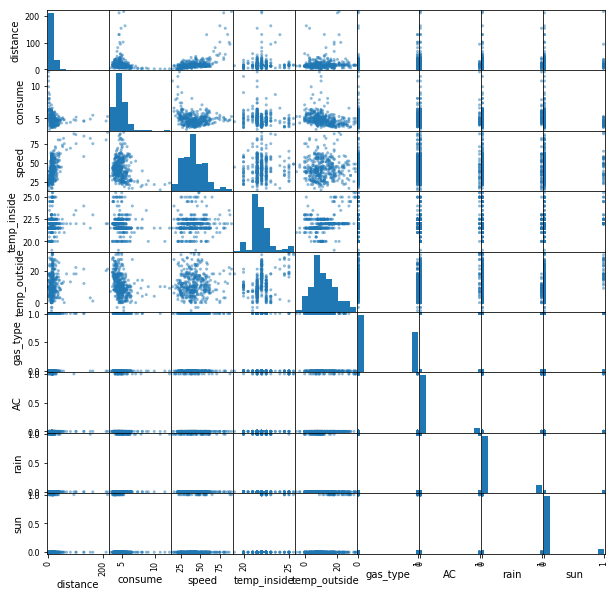

In [284]:
# 散布図行列を描画
pd.plotting.scatter_matrix(df, figsize=(10,10))
plt.show()

## 相関係数を表示

- pandas の corr 関数を利用

In [285]:
# 相関係数を確認
df.corr()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
distance,1.000000,-0.128967,0.562299,0.075178,0.088175,0.053411,-0.025738,-0.019791,0.081120
consume,-0.128967,1.000000,-0.227866,-0.160623,-0.320811,0.015327,0.096591,0.248118,-0.170667
speed,0.562299,-0.227866,1.000000,0.059293,0.015411,0.097360,-0.035408,0.009489,0.081618
temp_inside,0.075178,-0.160623,0.059293,1.000000,0.359500,-0.010198,0.297376,-0.036937,0.242248
temp_outside,0.088175,-0.320811,0.015411,0.359500,1.000000,-0.148705,0.167562,-0.186315,0.346903
gas_type,0.053411,0.015327,0.097360,-0.010198,-0.148705,1.000000,-0.105285,-0.060328,-0.022761
AC,-0.025738,0.096591,-0.035408,0.297376,0.167562,-0.105285,1.000000,0.242915,0.088598
rain,-0.019791,0.248118,0.009489,-0.036937,-0.186315,-0.060328,0.242915,1.000000,-0.112650
sun,0.081120,-0.170667,0.081618,0.242248,0.346903,-0.022761,0.088598,-0.112650,1.000000


## 相関係数をヒートマップにして可視化

- consume と speed、consume と temp_outside については、やや大きめの「負の」相関が見られる、ということか？

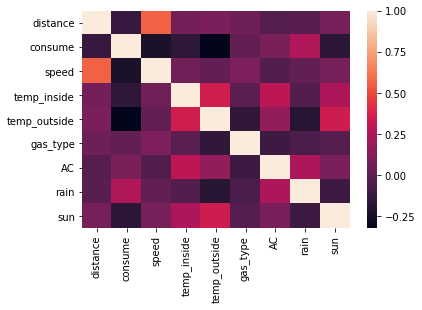

In [286]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df.corr())
plt.show()

## 線形回帰、重みの計算

- 目的変数
  - consume
- 説明変数
  - distance、speed、temp_inside、temp_outside, gas_type, AC, rain, sun

- 上記のとおりとする。目的変数は、いずれも数値として表せているカラムをいったん採用する。

In [287]:
# 目的変数（ numpy の array に変換）
y = df["consume"].values
# 説明変数（distance、speed、temp_inside、temp_outside, gas_type, AC, rain, sun カラム（いずれも数値として表せているカラム）を採用。
# これらを numpy の array に変換）
X = df[['distance', 'speed', 'temp_inside', 'temp_outside', 'gas_type', 'AC', 'rain', 'sun']].values

## 交差検証（クロスバリデーション）法を用いて汎用誤差を評価する

In [288]:
n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_squared_error = 0
cross_valid_mae = 0
cross_valid_mse = 0
split_num = 1
weights = []

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

    # 学習用データ、テスト用データを標準化（目的変数は標準化しなくても良いのか？）
    stdsc = StandardScaler()
    X_train = stdsc.fit_transform(X_train)
    X_test = stdsc.fit_transform(X_test)

    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    print("#### Fold %s"%split_num)

    ## 算出された重みの値を表示
    #w0 = regr.intercept_
    #w1 = regr.coef_[0]
    #w2 = regr.coef_[1]
    #w3 = regr.coef_[2]
    #w4 = regr.coef_[3]
    #w5 = regr.coef_[4]
    #w6 = regr.coef_[5]
    #w7 = regr.coef_[6]
    #w8 = regr.coef_[7]
    #print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8))
    weights = regr.coef_ # 重みの値を保存

    # テストデータに対する二乗誤差を計算
    squared_error = 0.5 * np.sum((y_test - y_pred_test) ** 2)
    print('二乗誤差 = {:.3f}'.format(squared_error))
    cross_valid_squared_error += squared_error #後で平均を取るために二乗誤差を加算

    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("MAE = %s"%round(mae, 3))
    cross_valid_mae += mae #後で平均を取るためにMAEを加算

    # テストデータに対するMSEを計算
    mse = mean_squared_error(y_test, y_pred_test) 
    print("MSE = %s"%round(mse,3) )  
    # テストデータに対するRMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )
    cross_valid_mse += mse #後で平均を取るためにMSEを加算

    print()    
    split_num += 1

#### Fold 1
二乗誤差 = 27.152
MAE = 0.68
MSE = 0.696
RMSE = 0.834

#### Fold 2
二乗誤差 = 29.533
MAE = 0.628
MSE = 0.757
RMSE = 0.87

#### Fold 3
二乗誤差 = 62.018
MAE = 0.732
MSE = 1.59
RMSE = 1.261

#### Fold 4
二乗誤差 = 34.725
MAE = 0.598
MSE = 0.902
RMSE = 0.95

#### Fold 5
二乗誤差 = 21.460
MAE = 0.517
MSE = 0.557
RMSE = 0.747



## DAY1 時点の二乗誤差、MAE、MSE、RMSE の値を保管

In [289]:
# DAY1 時点の二乗誤差、MAE、MSE、RMSE の値（ Day1_work_中山純平.ipynb からコピー）
squared_error_day1 = 171.364
mse_day1 = 0.912
mae_day1 = 0.636
rmse_day1 = 0.955

## 結果を表示（DAY1 と今回分との比較）

- 全体的に、DAY1 での結果と比べて、若干の改善が見られた。
- DAY1 からの変更点としては以下のとおり。
  - temp_inside カラムに空データがある行を、行ごと削除するのではなく、この空データを同カラムの平均値で置き換えた。
  - gas_type カラムの文字列データを、数値に変換した。（ "SP98" -> 0, "E10" -> 1 ）
  - この gas_type カラムと、AC, rain, sun カラムも説明変数に加えた。（いずれも数値として表せるカラム）
  - 説明変数の各値を標準化してから学習させるようにした。

In [290]:
# 取得した二乗誤差、MAE、MSEの平均値を最終的な汎化誤差値とする
final_squared_error = cross_valid_squared_error / n_split
final_mae = cross_valid_mae / n_split
final_mse = cross_valid_mse / n_split

# DAY1 時点の結果と合わせて表示
print('二乗誤差：　DAY1 = %s, 今回 = %s' % (round(squared_error_day1, 3), round(final_squared_error, 3)) )
print("MAE：　DAY1 = %s, 今回 = %s" % (round(mae_day1,3), round(final_mae, 3)) )
print("MSE：　DAY1 = %s, 今回 = %s" % (round(mse_day1,3), round(final_mse, 3)) )  
print("RMSE：　DAY1 = %s, 今回 = %s" % (round(rmse_day1, 3), round(np.sqrt(final_mse), 3)) )

二乗誤差：　DAY1 = 171.364, 今回 = 34.978
MAE：　DAY1 = 0.636, 今回 = 0.631
MSE：　DAY1 = 0.912, 今回 = 0.901
RMSE：　DAY1 = 0.955, 今回 = 0.949


## L2正則化（Ridge）を適用（交差検証法を用いて汎用誤差を評価）

In [291]:
n_split = 5 # グループ数を設定（今回は5分割）

ridge_cross_valid_squared_error = 0
ridge_cross_valid_mae = 0
ridge_cross_valid_mse = 0
split_num = 1
ridge_weights = []

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

    # 学習用データ、テスト用データを標準化（目的変数は標準化しなくても良いのか？）
    stdsc = StandardScaler()
    X_train = stdsc.fit_transform(X_train)
    X_test = stdsc.fit_transform(X_test)

    # 学習用データを使って線形回帰モデル（L2正則化（Ridge）付き）を学習
    alpha = 1e-1 # or 1e-5 or 1e-8
    regr = Ridge(alpha=alpha)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    #print("#### Fold %s"%split_num)

    ## 算出された重みの値を表示
    #w0 = regr.intercept_
    #w1 = regr.coef_[0]
    #w2 = regr.coef_[1]
    #w3 = regr.coef_[2]
    #w4 = regr.coef_[3]
    #w5 = regr.coef_[4]
    #w6 = regr.coef_[5]
    #w7 = regr.coef_[6]
    #w8 = regr.coef_[7]
    #print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8))
    ridge_weights = regr.coef_ # 重みの値を保存
    
    # テストデータに対する二乗誤差を計算
    squared_error = 0.5 * np.sum((y_test - y_pred_test) ** 2)
    #print('二乗誤差 = {:.3f}'.format(squared_error))
    ridge_cross_valid_squared_error += squared_error #後で平均を取るために二乗誤差を加算

    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    #print("MAE = %s"%round(mae, 3))
    ridge_cross_valid_mae += mae #後で平均を取るためにMAEを加算

    # テストデータに対するMSEを計算
    mse = mean_squared_error(y_test, y_pred_test) 
    #print("MSE = %s"%round(mse,3) )  
    # テストデータに対するRMSEを計算
    rmse = np.sqrt(mse)
    #print("RMSE = %s"%round(rmse, 3) )
    ridge_cross_valid_mse += mse #後で平均を取るためにMSEを加算

    print()    
    split_num += 1

## L1正規化（Lasso）を適用（交差検証法を用いて汎用誤差を評価）

In [292]:
n_split = 5 # グループ数を設定（今回は5分割）

lasso_cross_valid_squared_error = 0
lasso_cross_valid_mae = 0
lasso_cross_valid_mse = 0
split_num = 1
lasso_weights = []

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ

    # 学習用データ、テスト用データを標準化（目的変数は標準化しなくても良いのか？）
    stdsc = StandardScaler()
    X_train = stdsc.fit_transform(X_train)
    X_test = stdsc.fit_transform(X_test)

    # 学習用データを使って線形回帰モデル（L1正則化（Lasso）付き）を学習
    alpha = 1e-1 # or 1e-5 or 1e-8
    regr = Lasso(alpha=alpha)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    #print("#### Fold %s"%split_num)

    ## 算出された重みの値を表示
    #w0 = regr.intercept_
    #w1 = regr.coef_[0]
    #w2 = regr.coef_[1]
    #w3 = regr.coef_[2]
    #w4 = regr.coef_[3]
    #w5 = regr.coef_[4]
    #w6 = regr.coef_[5]
    #w7 = regr.coef_[6]
    #w8 = regr.coef_[7]
    #print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8))
    lasso_weights = regr.coef_ # 重みの値を保存

    # テストデータに対する二乗誤差を計算
    squared_error = 0.5 * np.sum((y_test - y_pred_test) ** 2)
    #print('二乗誤差 = {:.3f}'.format(squared_error))
    lasso_cross_valid_squared_error += squared_error #後で平均を取るために二乗誤差を加算

    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    #print("MAE = %s"%round(mae, 3))
    lasso_cross_valid_mae += mae #後で平均を取るためにMAEを加算

    # テストデータに対するMSEを計算
    mse = mean_squared_error(y_test, y_pred_test) 
    #print("MSE = %s"%round(mse,3) )  
    # テストデータに対するRMSEを計算
    rmse = np.sqrt(mse)
    #print("RMSE = %s"%round(rmse, 3) )
    lasso_cross_valid_mse += mse #後で平均を取るためにMSEを加算

    print()    
    split_num += 1

## 重みの値を比較（正則化なし、L2正則化、L1正則化を比較）

- 正則化なしのパターンと、Ridge（L2正則化）適用パターンでは、ほぼ同じ重みの値が得られた
- Lasso（L1正則化）適用パターンでは、値が小さくなった部分と、大きくなった部分の両方が見られた

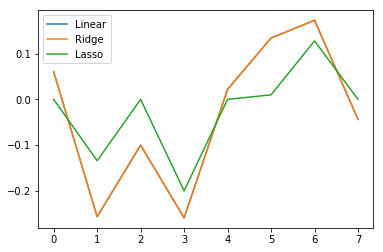

In [293]:
plt.plot([0, 1, 2, 3, 4, 5, 6, 7], weights, label='Linear')
plt.plot([0, 1, 2, 3, 4, 5, 6, 7], ridge_weights, label='Ridge')
plt.plot([0, 1, 2, 3, 4, 5, 6, 7], lasso_weights, label='Lasso')
plt.legend()
plt.show()

## 結果を表示（正則化なし、L2正則化、L1正則化を比較）

- MAE に関しては、Lasso（L1正則化）がいちばん小さい値となった。
- MSE、RMSE については、Ridge（L2正則化）パターンで、いちばん小さい値となった。
- どちらのパターンが決定的によい、というのが判断が難しい状況。

In [294]:
# 取得した二乗誤差、MAE、MSEの平均値を最終的な汎化誤差値とする（ Ridge、Lasso ）
ridge_final_squared_error = ridge_cross_valid_squared_error / n_split
ridge_final_mae = ridge_cross_valid_mae / n_split
ridge_final_mse = ridge_cross_valid_mse / n_split
lasso_final_squared_error = lasso_cross_valid_squared_error / n_split
lasso_final_mae = lasso_cross_valid_mae / n_split
lasso_final_mse = lasso_cross_valid_mse / n_split

# DAY1 時点の結果と合わせて表示
print('二乗誤差： 正則化なし = {:.6f}, Ridge = {:.6f}, Lasso = {:.6f}'.format(final_squared_error, ridge_final_squared_error, lasso_final_squared_error))
print("MAE： 正則化なし = %s, Ridge = %s, Lasso = %s" % (round(final_mae,6), round(ridge_final_mae,6), round(lasso_final_mae,6) ))
print("MSE： 正則化なし = %s, Ridge = %s, Lasso = %s" % (round(final_mse,6), round(ridge_final_mse,6), round(lasso_final_mse,6) ))
print("RMSE： 正則化なし = %s, Ridge = %s, Lasso = %s" % (round(np.sqrt(final_mse),6), round(np.sqrt(ridge_final_mse),6), round(np.sqrt(lasso_final_mse),6) ))

二乗誤差： 正則化なし = 34.977713, Ridge = 34.976735, Lasso = 35.991589
MAE： 正則化なし = 0.631163, Ridge = 0.631137, Lasso = 0.618693
MSE： 正則化なし = 0.900606, Ridge = 0.900581, Lasso = 0.926864
RMSE： 正則化なし = 0.949003, Ridge = 0.94899, Lasso = 0.962738
